In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing
from joblib import Parallel, delayed

from mpl_toolkits import mplot3d
from math import pi
from scipy.interpolate import RectBivariateSpline
from torch.nn.functional import pad

In [3]:
N = 25
I_size = 2*N + 1

I_size

51

In [4]:
def plot_tensor(t, wireframe=False):
    X, Y = np.mgrid[0:t.shape[0], 0:t.shape[1]]
    fig = plt.figure()
    ax = mplot3d.Axes3D(fig)
    Z = t.numpy()
    if wireframe:
        ax.plot_wireframe(X, Y, Z, rstride=1, cstride=1, cmap='hot')
    else:        
        ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='hot')
    plt.show()

def plot_mat(t):
    im = plt.imshow(t, cmap='hot')
    plt.xscale(value='linear')
    plt.colorbar()
    plt.show()

def phase_to_complex(phi):
    return torch.stack([torch.cos(phi), torch.sin(phi)], dim=-1)    

def interpolate(t, nx, ny):
    dx, dy = t.shape
    X, Y = np.ogrid[0:nx:dx *1j], np.ogrid[0:ny:dy *1j]
    f = RectBivariateSpline(X, Y, t)
    interpd = torch.tensor(f(np.ogrid[0:nx], 
                             np.ogrid[0:ny]))
    interpd += max(0, -interpd.min())
    return interpd/interpd.max()


def random_interpolated(N, seed_size):
    x = torch.rand(seed_size, seed_size)
    N = 2*N + 1
    res = interpolate(x, N, N)
    return res

def process_interpolated(t):
    m = 2*pi*t
    m = phase_to_complex(m)
    padding = (0, 0, 0, 2 * N, 0, 2 * N)
    return pad(m, padding)

def interpolate_and_pad(bs, N, seed_size=5):
    cpus = multiprocessing.cpu_count()
    res =  Parallel(n_jobs=cpus) (delayed(random_interpolated)(N, seed_size) for _ in range(bs)) 
    res =  torch.stack(res)
    res = 2*pi * res
    res = phase_to_complex(res)
    padding = (0, 0, 0, 2 * N, 0, 2 * N)
    return pad(res, padding)
    

def process_padded(t):
    dft = torch.fft(t, 2).cpu()
    dft = (dft ** 2).sum(dim=-1)
    return dft

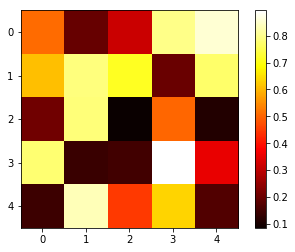

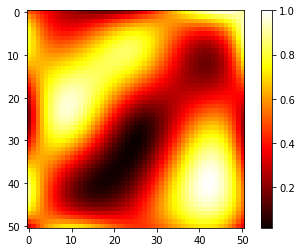

(None, None)

In [5]:
x = torch.rand(5, 5)
interp_x = interpolate(x, 51, 51)
plot_mat(x), plot_mat(interp_x)

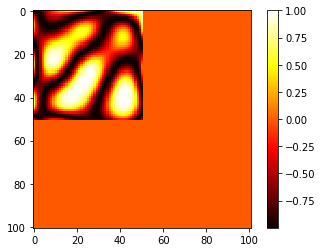

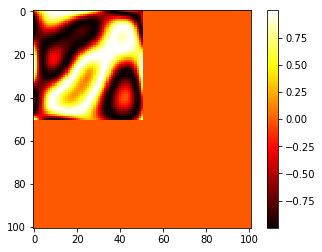

In [6]:
padded = process_interpolated(interp_x)
dft = torch.fft(padded, 2)
cp = (padded[:, :, 0].numpy() + 1j * padded[:, :, 1].numpy())
dft = np.fft.fft2(cp)
res = np.square(dft.real) + np.square(dft.imag)
plot_mat(padded[:, :, 0])
plot_mat(padded[:, :, 1])

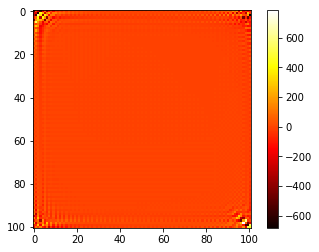

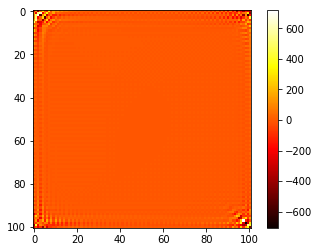

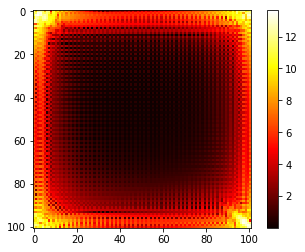

In [7]:
plot_mat(dft.real), plot_mat(dft.imag)
plot_mat(np.log(res + 1))

In [8]:
def interpolate_flat_batch(batch, intrp_size=51):
    cpus = multiprocessing.cpu_count()
    b = batch.reshape(-1, 5, 5)
    res =  Parallel(n_jobs=cpus) (delayed(interpolate)(t, intrp_size, intrp_size) for t in b) 
    res =  torch.stack(res)
    return res



In [ ]:
torch.manual_seed(42)
x = torch.rand(1_000_000, 5, 5).flatten(start_dim=1)
np.savetxt('seeds.csv', x, delimiter=',')

In [27]:
import pandas as pd
x = pd.read_csv('seeds.csv', header=None)
x.columns = [str(i) for i in x.columns]
x.to_feather('seeds.feather')

In [9]:
import pandas as pd
import time
import feather
x = feather.read_dataframe('seeds.feather')
for i in range(20):
    bs = 50_000
    file_name = 'raw_data/interpolated_tensor_' + str(i)
    tt = interpolate_flat_batch(np.array(x.iloc[i * bs:min(len(x), (i+1) * bs),:]))
    torch.save(tt, file_name)
    print(i, time.asctime())
    

0 Sun Dec  9 14:04:07 2018
1 Sun Dec  9 14:04:16 2018
2 Sun Dec  9 14:04:25 2018
3 Sun Dec  9 14:04:34 2018
4 Sun Dec  9 14:04:42 2018
5 Sun Dec  9 14:04:51 2018
6 Sun Dec  9 14:05:00 2018
7 Sun Dec  9 14:05:09 2018
8 Sun Dec  9 14:05:18 2018
9 Sun Dec  9 14:05:26 2018
10 Sun Dec  9 14:05:34 2018
11 Sun Dec  9 14:05:42 2018
12 Sun Dec  9 14:05:50 2018
13 Sun Dec  9 14:05:58 2018
14 Sun Dec  9 14:06:07 2018
15 Sun Dec  9 14:06:14 2018
16 Sun Dec  9 14:06:22 2018
17 Sun Dec  9 14:06:30 2018
18 Sun Dec  9 14:06:38 2018
19 Sun Dec  9 14:06:46 2018


In [5]:
def process_interpolated_batch(t):
    res = 2*pi * t
    res = phase_to_complex(res)
    padding = (0, 0, 0, 2 * N, 0, 2 * N)
    padded = pad(res, padding)    
    res = (padded[:, :, :, 0].numpy() + 1j * padded[:, :, :, 1].numpy())
    res = np.fft.fft2(res)
    return np.square(res.real) + np.square(res.imag)

In [10]:
res = torch.load('raw_data/interpolated_tensor_0')
res = process_interpolated_batch(res)
#torch.save(tor'raw_data/square_moduli_0')

In [18]:
import gc
import time
for i in range(20):
    file_name = 'raw_data/interpolated_tensor_' + str(i)
    output_name = 'raw_data/square_moduli_' + str(i)
    tt = torch.load(file_name)
    tt = process_interpolated_batch(tt)
    np.save(output_name, tt)
    del tt
    gc.collect()
    print(i, time.asctime())

0 Sun Dec  9 14:50:09 2018
1 Sun Dec  9 14:50:33 2018
2 Sun Dec  9 14:50:58 2018
3 Sun Dec  9 14:51:24 2018
4 Sun Dec  9 14:51:49 2018
5 Sun Dec  9 14:52:14 2018
6 Sun Dec  9 14:52:39 2018
7 Sun Dec  9 14:53:04 2018
8 Sun Dec  9 14:53:29 2018
9 Sun Dec  9 14:53:54 2018
10 Sun Dec  9 14:54:20 2018
11 Sun Dec  9 14:54:45 2018
12 Sun Dec  9 14:55:11 2018
13 Sun Dec  9 14:55:36 2018
14 Sun Dec  9 14:56:01 2018
15 Sun Dec  9 14:56:26 2018
16 Sun Dec  9 14:56:52 2018
17 Sun Dec  9 14:57:17 2018
18 Sun Dec  9 14:57:42 2018
19 Sun Dec  9 14:58:08 2018


In [19]:
inpt = np.load('raw_data/square_moduli_0.npy')
outpt = torch.load('raw_data/interpolated_tensor_0')

In [20]:
import matplotlib.pyplot as plt

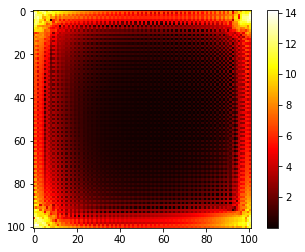

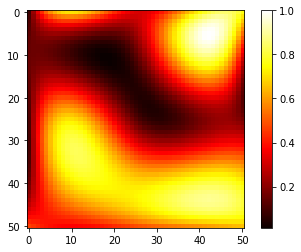

(None, None)

In [28]:
img_i = 1238
plot_mat(np.log(inpt[img_i,:]+1)), plot_mat(outpt[img_i, :])